## Using SVM Models on crypto price trend prediction

In [36]:
# Preliminary code needed for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# Import data API
from data import series

import numpy as np

# This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task
# (multi-output regression in the multiclass case).
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D



import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import datetime
import json
import numpy as np
import pandas as pd
import requests
import time
import warnings
warnings.simplefilter('ignore')

import talib as ta
from talib import MA_Type

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker



ModuleNotFoundError: No module named 'plotly'

### Data Import Functions

In [6]:
 def gen_X_y(symbol: str, timeframe: str):
    # Create a series for BTC-USDT pair on 1h candles
    # btc = series.DataSeries('BTCUSDT', '1h')
    btc = series.DataSeries(symbol, timeframe)
    data = btc.getData()
    #data
    # print(data.keys())

    price_close = data['close']
    # print(len(price_close))
    
    prev5 = np.concatenate([
            # pivot timeframe
            price_close[np.newaxis, 5:],
            # previous 5 timeframes
            price_close[np.newaxis, 4:-1], # 1 frame ago
            price_close[np.newaxis, 3:-2], # 2 frame ago
            price_close[np.newaxis, 2:-3], # 3 frame ago
            price_close[np.newaxis, 1:-4], # 4 frame ago
            price_close[np.newaxis, :-5],  # 5 frame ago
        ],
        axis = 0
    )

    # Generate truth values (y)
    y = prev5[0, :] > np.amin(prev5[1:, :], axis = 0)
#     print('timeframe:', timeframe)
#     print('number of times where trend is up: ', y[y == True].shape)
#     print('number of times where trend is down: ', y[y == False].shape)
    
    btc.addIndicator('RSI', data['close'], 30) # 30-timeframe RSI

    btc.addIndicator('EMA', data['close'], 30) # 30-timeframe EMA
    # btc1h.addIndicator('EMA', btc1h.getData()['close'], 50) # 50-timeframe EMA

    ## MFI: https://www.investopedia.com/terms/m/mfi.asp
    btc.addIndicator('MFI', data['high'], data['low'], data['close'], data['volume'], 10) # 10-timeframe MFI

    ## MACD: https://www.investopedia.com/terms/m/macd.asp
    btc.addIndicator('MACD', data['close'], 12, 26) # fast = 12, slow = 26

    indicators = btc.getIndicators()
    #for indicator in indicators.keys():
        #print(indicator)
      
    time_cut = 50

    # Each technical indicator consists one column of X.
    X = np.concatenate(
        (
            indicators['RSI'][np.newaxis, time_cut:].T,
            indicators['EMA'][np.newaxis, time_cut:].T,
            indicators['MFI'][np.newaxis, time_cut:].T
        ),
        axis = 1
    )
    
   # X_1 =my_data.loc[:, my_data.columns != 'y']
    # print('shape of X:', X.shape)
    # print('shape of y:', y.shape)

    y_truncate = y[(time_cut - 5):]
    
    return (X, y_truncate)

### Hour timeframe data, correcting imbalanced data, creating train and test sets

In [7]:
X_h, y_h = gen_X_y('BTCUSDT', '1h')


# Split train/test sets
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h)
print('X, y generated from 1h-scale data')
print('train set size:', y_train_h.shape)
print('test set size:', y_test_h.shape)



print('hour scale price data')
print('True count:', len(y_h[y_h == True]))
print('False count:', len(y_h[y_h == False]))

indices = np.where(y_h == True)[0]
if len(y_h[y_h == True]) > len(y_h[y_h == False]):
    indices = np.random.choice(indices, size = len(y_h[y_h == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_h == False)[0]))
seed =1234
X_train_h_even, X_test_h_even, y_train_h_even, y_test_h_even = train_test_split(X_h[indices], y_h[indices])
print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))

X, y generated from 1h-scale data
train set size: (22967,)
test set size: (7656,)
hour scale price data
True count: 24621
False count: 6002
Train set True/False ratio: 4492 / 4511
Test set True/False ratio: 1510 / 1491


### Day timeframe data, correcting imbalanced data, creating train and test sets

In [9]:
X_d, y_d = gen_X_y('BTCUSDT', '1d')

# Split train/test sets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d)
print('X, y generated from 1d-scale data')
print('train set size:', y_train_d.shape)
print('test set size:', y_test_d.shape)

print('day scale price data')
print('True count:', len(y_d[y_d == True]))
print('False count:', len(y_d[y_d == False]))

indices = np.where(y_d == True)[0]
if len(y_d[y_d == True]) > len(y_d[y_d == False]):
    indices = np.random.choice(indices, size = len(y_d[y_d == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_d == False)[0]))
seed =1234
X_train_d_even, X_test_d_even, y_train_d_even, y_test_d_even = train_test_split(X_d[indices], y_d[indices])
print('Total dataset size (train + test):', indices.shape[0])
print('Train set True/False ratio:', len(np.where(y_train_d_even == True)[0]), '/', len(np.where(y_train_d_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_d_even == True)[0]), '/', len(np.where(y_test_d_even == False)[0]))


X, y generated from 1d-scale data
train set size: (924,)
test set size: (309,)
day scale price data
True count: 1000
False count: 233
Total dataset size (train + test): 466
Train set True/False ratio: 173 / 176
Test set True/False ratio: 60 / 57


## Starting the SVM Modelling

In [10]:

# Scale all the x variables 
scaled_x_train = StandardScaler().fit_transform(X_train_d_even)
scaled_x_test=StandardScaler().fit_transform(X_test_d_even)



In [11]:
# running the svm model with no parameter tuning 
svmmodel = SVC(gamma='auto')
svmmodel.fit(X_train_d_even, y_train_d_even)
y_predict_train = svmmodel.predict(scaled_x_train)
y_predict_test = svmmodel.predict(scaled_x_test)

In [12]:
# check the train-set accuracy 
train_accuracy = accuracy_score(y_train_d_even,y_predict_train)
train_accuracy

0.504297994269341

In [13]:
# check the test-set accuracy 
test_accuracy = accuracy_score(y_test_d_even,y_predict_test)
test_accuracy

0.48717948717948717

In [26]:
# Parameter Tuning using different Kernel and different values of C

svm_parameters = {'kernel':('linear', 'rbf'), 'C':[0.001,0.01, 0.1, 1.0,10.0, 100.0,1000.0]}
        # ADD CODE HERE
svc = SVC(gamma='auto')
svm_cv = GridSearchCV(svc,svm_parameters,n_jobs=-1,return_train_score=True)
svm_cv.fit(scaled_x_train,y_train_d_even)


GridSearchCV(estimator=SVC(gamma='auto'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'kernel': ('linear', 'rbf')},
             return_train_score=True)

In [27]:
# best score for the svm model 
best_score= svm_cv.best_score_
best_score

0.676231884057971

In [28]:
y_predict_train = svm_cv.predict(scaled_x_train)
y_predict_test = svm_cv.predict(scaled_x_test)

In [29]:
train_accuracy = accuracy_score(y_train_d_even, y_predict_train)
test_accuracy = accuracy_score(y_test_d_even, y_predict_test)


In [30]:
print(train_accuracy)
print(test_accuracy)

0.7106017191977078
0.6410256410256411


In [31]:
rank_test_score = svm_cv.cv_results_['rank_test_score']
rank_test_score

array([12, 13,  9, 13,  2,  3,  4,  1,  4,  8,  4, 10,  4, 11])

In [32]:
mean_test_score = svm_cv.cv_results_['mean_test_score']
mean_test_score

array([0.51585921, 0.50430642, 0.66761905, 0.50430642, 0.67619048,
       0.67333333, 0.67329193, 0.67623188, 0.67329193, 0.6705176 ,
       0.67329193, 0.63602484, 0.67329193, 0.61022774])

In [33]:
svm_cv.cv_results_

# lin 0.01, rbf 0.01, lin 0.1, rbf 0.1, lin 1.0, rbf 1.0 
#0.66761905, 0.50430642, 0.67619048, 0.67333333, 0.67329193, 0.67623188



{'mean_fit_time': array([0.00979605, 0.00800042, 0.00879974, 0.0075994 , 0.00559921,
        0.01180129, 0.00760055, 0.00731792, 0.01360145, 0.00840025,
        0.08836265, 0.02435942, 0.47980084, 0.21229291]),
 'std_fit_time': array([0.00247779, 0.00063295, 0.0044463 , 0.00079914, 0.00185566,
        0.0059809 , 0.00320005, 0.00077481, 0.00265347, 0.0010194 ,
        0.02559945, 0.00238946, 0.09183802, 0.07576667]),
 'mean_score_time': array([0.00280128, 0.00280099, 0.00139999, 0.00240097, 0.00280228,
        0.00219946, 0.00140109, 0.00182891, 0.00199962, 0.0015996 ,
        0.00760002, 0.00179963, 0.00406995, 0.00140061]),
 'std_score_time': array([0.00074746, 0.00075026, 0.00049008, 0.00049059, 0.00098024,
        0.00040028, 0.00049035, 0.00050956, 0.00063196, 0.0004908 ,
        0.01072528, 0.00097973, 0.00538178, 0.00048831]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0,
                    10.0, 100.0, 100.0, 1000.0, 1000.0],
              

### Plotting the SVM graphs

In [24]:
x_min, x_max = scaled_x_test[:, 0:2].min() - 1, scaled_x_test[:, 0:2].max() + 1

x_min, x_max

(-3.7597230886893622, 4.632646056030115)

In [25]:

h = .02  # step size in the mesh


svc_lin_01 = svm.SVC(kernel='linear', C=0.01, gamma='auto').fit(scaled_x_train,y_train_d_even)
svc_lin_1 = svm.SVC(kernel='linear', C=0.1, gamma='auto').fit(scaled_x_train,y_train_d_even)
svc_lin_10 = svm.SVC(kernel='linear', C=1, gamma='auto').fit(scaled_x_train,y_train_d_even)

svc_rbf_01 = svm.SVC(kernel='rbf', C=0.01, gamma='auto').fit(scaled_x_train,y_train_d_even)
svc_rbf_1 = svm.SVC(kernel='rbf', C=0.1, gamma='auto').fit(scaled_x_train,y_train_d_even)
svc_rbf_10 = svm.SVC(kernel='rbf', C=1, gamma='auto').fit(scaled_x_train,y_train_d_even)








# create a mesh to plot in
x_min, x_max = scaled_x_test[:, 0:2].min() - 1, scaled_x_test[:, 0:2].max() + 1
y_min, y_max = y_test_d_even.min() - 1, y_test_d_even.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['linear kernel with C=0.01',
          'linear kernel with C=0.1',
          'linear kernel with C=1',
          'Rbf kernel with C=0.01',
          'Rbf kernel with C=0.1',
          'Rbf kernel with C=1']


for i, clf in enumerate((svc_lin_01, svc_lin_1, svc_lin_10, svc_rbf_01,svc_rbf_1,svc_rbf_10)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    #plt.subplot(3, 3, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    

plt.show()

ValueError: X.shape[1] = 2 should be equal to 3, the number of features at training time

<Figure size 432x288 with 0 Axes>

In [ ]:
max_abs_scaler = preprocessing.MaxAbsScaler()

Model_Dict = {}

for i in Ticker_List:
    Stock_Data[i].dropna(inplace=True)
    
    
    X = max_abs_scaler.fit_transform(X)
    Y = np.array(Stock_Data[i]['Signal'])
   
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    
    Model_Dict[i] = {}
    Model_Dict[i]['X Train'] = X_train
    Model_Dict[i]['X Test'] = X_test
    Model_Dict[i]['Y Train'] = y_train
    Model_Dict[i]['Y Test'] = y_test
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    #model = svm.SVC(kernel='linear')
    #model = svm.SVC(kernel='linear',decision_function_shape='ovo')
    #model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    #model = svm.SVC(kernel='poly')
    #model = svm.SVC(kernel='poly',decision_function_shape='ovo')
    #model = svm.SVC(kernel='sigmoid')
    #model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')
    
    model.fit(Model_Dict[i]['X Train'], Model_Dict[i]['Y Train'])
    y_pred = model.predict(Model_Dict[i]['X Test'])
    
    Model_Dict[i]['Y Prediction'] = y_pred
    
    
    #print("SVM Model Info for Ticker: "+i)
    #print("Accuracy:",metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction']))
    Model_Dict[i]['Accuracy'] = metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'])
    #print("Precision:",metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
    Model_Dict[i]['Precision'] = metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro")
    #print("Recall:",metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
    Model_Dict[i]['Recall'] = metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro")

## Define a function to generate X, y from raw data (Use Karan's data API)

In [7]:
def gen_X_y(symbol: str, timeframe: str):
    # Create a series for BTC-USDT pair on 1h candles
    # btc = series.DataSeries('BTCUSDT', '1h')
    btc = series.DataSeries(symbol, timeframe)
    data = btc.getData()
    
    # print(data.keys())

    price_close = data['close']
    # print(len(price_close))
    
    prev5 = np.concatenate([
            # pivot timeframe
            price_close[np.newaxis, 5:],
            # previous 5 timeframes
            price_close[np.newaxis, 4:-1], # 1 frame ago
            price_close[np.newaxis, 3:-2], # 2 frame ago
            price_close[np.newaxis, 2:-3], # 3 frame ago
            price_close[np.newaxis, 1:-4], # 4 frame ago
            price_close[np.newaxis, :-5],  # 5 frame ago
        ],
        axis = 0
    )

    # Generate truth values (y)
    y = prev5[0, :] > np.amin(prev5[1:, :], axis = 0)
    print('timeframe:', timeframe)
    print('number of times where trend is up: ', y[y == True].shape)
    print('number of times where trend is down: ', y[y == False].shape)
    
    btc.addIndicator('RSI', data['close'], 30) # 30-timeframe RSI

    btc.addIndicator('EMA', data['close'], 30) # 30-timeframe EMA
    # btc1h.addIndicator('EMA', btc1h.getData()['close'], 50) # 50-timeframe EMA

    ## MFI: https://www.investopedia.com/terms/m/mfi.asp
    btc.addIndicator('MFI', data['high'], data['low'], data['close'], data['volume'], 10) # 10-timeframe MFI

    ## MACD: https://www.investopedia.com/terms/m/macd.asp
    btc.addIndicator('MACD', data['close'], 12, 26) # fast = 12, slow = 26

    indicators = btc.getIndicators()
    print(indicators)
    #for indicator in indicators.keys():
        #print(indicator)
        
    time_cut = 50

    # Each technical indicator consists one column of X.
    X = np.concatenate(
        (
            indicators['RSI'][np.newaxis, time_cut:].T,
            indicators['EMA'][np.newaxis, time_cut:].T,
            indicators['MFI'][np.newaxis, time_cut:].T
        ),
        axis = 1
    )
    # print('shape of X:', X.shape)
    # print('shape of y:', y.shape)

    y_truncate = y[(time_cut - 5):]
    
    return (X, y_truncate)

## Generate X, y from 1h-scale data

In [64]:
X_h, y_h = gen_X_y('BTCUSDT', '1h')


# Split train/test sets
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h)
print('X, y generated from 1h-scale data')
print('train set size:', y_train_h.shape)
print('test set size:', y_test_h.shape)



timeframe: 1h
number of times where trend is up:  (24655,)
number of times where trend is down:  (6013,)
X, y generated from 1h-scale data
train set size: (22967,)
test set size: (7656,)


## Generate X, y from 1d-scale data

In [65]:
X_d, y_d = gen_X_y('BTCUSDT', '1d')

# Split train/test sets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d)
print('X, y generated from 1d-scale data')
print('train set size:', y_train_d.shape)
print('test set size:', y_test_d.shape)





timeframe: 1d
number of times where trend is up:  (1039,)
number of times where trend is down:  (239,)
X, y generated from 1d-scale data
train set size: (924,)
test set size: (309,)


## Ridge Classifier

## Logistic Regression

According to the above results from `Ridge Classifier` & `Logistic Regression`, these **linear** models are working quite well on the price data.

### The problem is that our dataset itself is skewed (in terms of the Truth label ratio). 80% or above consists of `True` labels for the `BUY` signal (whether we use `1h` scale or `1d` scale price data). We need to try training the classifiers using a dataset that consists of roughly 50% of `True` labels..

## Let's try training the linear models with data that have 50/50 rate of True/False labels.

In [10]:
print('hour scale price data')
print('True count:', len(y_h[y_h == True]))
print('False count:', len(y_h[y_h == False]))

indices = np.where(y_h == True)[0]
if len(y_h[y_h == True]) > len(y_h[y_h == False]):
    indices = np.random.choice(indices, size = len(y_h[y_h == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_h == False)[0]))
seed =1234
X_train_h_even, X_test_h_even, y_train_h_even, y_test_h_even = train_test_split(X_h[indices], y_h[indices])
print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))

# Adding new code 
n_x_train = normalize(X_train_h_even)
n_x_test = normalize(X_test_h_even)


svm = SVC(gamma='auto')
svm.fit(n_x_train, X_train_h_even)


params_svc = {'C': [0.01,0.1, 1.0], 'kernel': ['linear', 'rbf']}
tuned_svc = SVC(gamma='auto')
svm2 = GridSearchCV(tuned_svc, params_svc, cv = 10)
svm2.fit(n_x_train, y_train_h_even)
print("best score: %f" % svm2.best_score_)


res_train_svm2 = svm2.predict(n_x_train)
score_train_svm2 = accuracy_score(res_train_svm2, y_train_h_even)

res_test_svm2 = svm2.predict(n_x_test)
score_test_svm2 = accuracy_score(res_test_svm2, y_test_h_even)



# original code 

# svr = svm.SVC(kernel='rbf', C=1e-5)
# #, gamma=0.1
# # Train the model 
# svr_clf_h_even = svr.fit(X_train_h_even, y_train_h_even)
# y_pred_test = svr_clf_h_even.predict(X_test_h_even)
# y_pred_train = svr_clf_h_even.predict(X_train_h_even)

# print('Accuracy of SVM Classifier (on 1h-scale data, 50/50 dataset)')
# print('training set accuracy:', accuracy_score(y_train_h_even, y_pred_train))
# print('test set accuracy:',    accuracy_score(y_test_h_even, y_pred_test) )





hour scale price data
True count: 24621
False count: 6002
Train set True/False ratio: 4522 / 4481
Test set True/False ratio: 1480 / 1521


ValueError: y should be a 1d array, got an array of shape (9003, 3) instead.

In [55]:
print('day scale price data')
print('True count:', len(y_d[y_d == True]))
print('False count:', len(y_d[y_d == False]))

indices = np.where(y_d == True)[0]
if len(y_d[y_d == True]) > len(y_d[y_d == False]):
    indices = np.random.choice(indices, size = len(y_d[y_d == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_d == False)[0]))
seed =1234
X_train_d_even, X_test_d_even, y_train_d_even, y_test_d_even = train_test_split(X_d[indices], y_d[indices])
print('Total dataset size (train + test):', indices.shape[0])
print('Train set True/False ratio:', len(np.where(y_train_d_even == True)[0]), '/', len(np.where(y_train_d_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_d_even == True)[0]), '/', len(np.where(y_test_d_even == False)[0]))

# ridge_clf_d_even = RidgeClassifier().fit(X_train_d_even, y_train_d_even)

# print('Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)')
# print('training set accuracy:', ridge_clf_d_even.score(X_train_d_even, y_train_d_even))
# print('test set accuracy:', ridge_clf_d_even.score(X_test_d_even, y_test_d_even))


svr = svm.SVC(kernel='rbf', C=1e5)
#, gamma=0.1
# Train the model 
svr_clf_d_even = svr.fit(X_train_d_even, y_train_d_even)
y_pred_test = svr_clf_d_even.predict(X_test_d_even)
y_pred_train = svr_clf_d_even.predict(X_train_d_even)

print('Accuracy of SVM Classifier (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', accuracy_score(y_train_d_even, y_pred_train))
print('test set accuracy:',    accuracy_score(y_test_d_even, y_pred_test) )


day scale price data
True count: 1000
False count: 233
Total dataset size (train + test): 466
Train set True/False ratio: 177 / 172
Test set True/False ratio: 56 / 61
Accuracy of SVM Classifier (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6762177650429799
test set accuracy: 0.6837606837606838


In [36]:
print('day scale price data')
print('True count:', len(y_d[y_d == True]))
print('False count:', len(y_d[y_d == False]))

indices = np.where(y_d == True)[0]
if len(y_d[y_d == True]) > len(y_d[y_d == False]):
    indices = np.random.choice(indices, size = len(y_d[y_d == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_d == False)[0]))

X_train_d_even, X_test_d_even, y_train_d_even, y_test_d_even = train_test_split(X_d[indices], y_d[indices])
print('Total dataset size (train + test):', indices.shape[0])
print('Train set True/False ratio:', len(np.where(y_train_d_even == True)[0]), '/', len(np.where(y_train_d_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_d_even == True)[0]), '/', len(np.where(y_test_d_even == False)[0]))

ridge_clf_d_even = RidgeClassifier().fit(X_train_d_even, y_train_d_even)

print('Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_d_even.score(X_train_d_even, y_train_d_even))
print('test set accuracy:', ridge_clf_d_even.score(X_test_d_even, y_test_d_even))

day scale price data
True count: 1000
False count: 233
Total dataset size (train + test): 466
Train set True/False ratio: 178 / 171
Test set True/False ratio: 55 / 62
Accuracy of Ridge Classifier (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6962750716332379
test set accuracy: 0.717948717948718


In [15]:
logi_clf_h_even = LogisticRegression(random_state=0).fit(X_train_h_even, y_train_h_even)
print('Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_h_even.score(X_train_h_even, y_train_h_even))
print('test set accuracy:', logi_clf_h_even.score(X_test_h_even, y_test_h_even), end = '\n\n')

logi_clf_d_even = LogisticRegression(random_state=0).fit(X_train_d_even, y_train_d_even)
print('Accuracy of Logistic Regression (on 1d-scale data, 50/50 dataset)')
print('training set accuracy:', logi_clf_d_even.score(X_train_d_even, y_train_d_even))
print('test set accuracy:', logi_clf_d_even.score(X_test_d_even, y_test_d_even))




Accuracy of Logistic Regression (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6593357769632345
test set accuracy: 0.6554481839386871

Accuracy of Logistic Regression (on 1d-scale data, 50/50 dataset)
training set accuracy: 0.6361031518624641
test set accuracy: 0.5042735042735043


Accuracy of Ridge Classifier (on 1h-scale data)
training set accuracy: 0.8060695780903034
test set accuracy: 0.8044670846394985


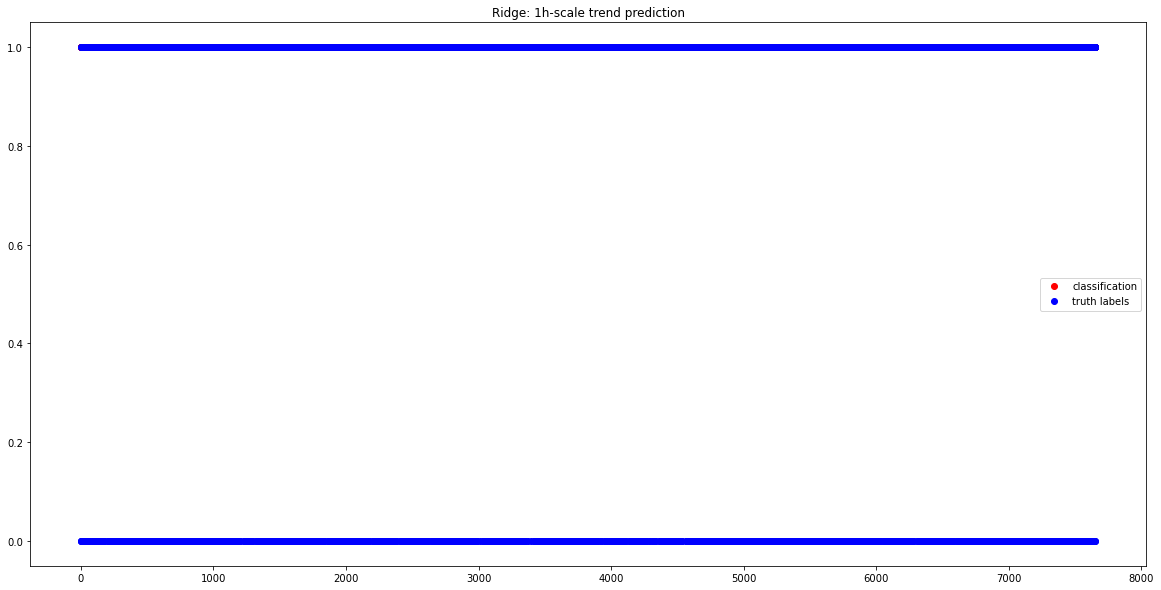

In [11]:
ridge_clf_h = RidgeClassifier().fit(X_train_h, y_train_h)

print('Accuracy of Ridge Classifier (on 1h-scale data)')
print('training set accuracy:', ridge_clf_h.score(X_train_h, y_train_h))
print('test set accuracy:', ridge_clf_h.score(X_test_h, y_test_h))
# print('test set accuracy:', accuracy_score(y_test_h, ridge_clf.predict(X_test_h))) # Exact same result as above
plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_h.shape[0]), ridge_clf_h.predict(X_test_h), 'ro', label = "classification")
plt.plot(np.arange(X_test_h.shape[0]), y_test_h, 'bo', label = "truth labels")
plt.title('Ridge: 1h-scale trend prediction')
plt.legend()
plt.show()

Accuracy of Ridge Classifier (on 1d-scale data)
training set accuracy: 0.8062770562770563
test set accuracy: 0.8284789644012945


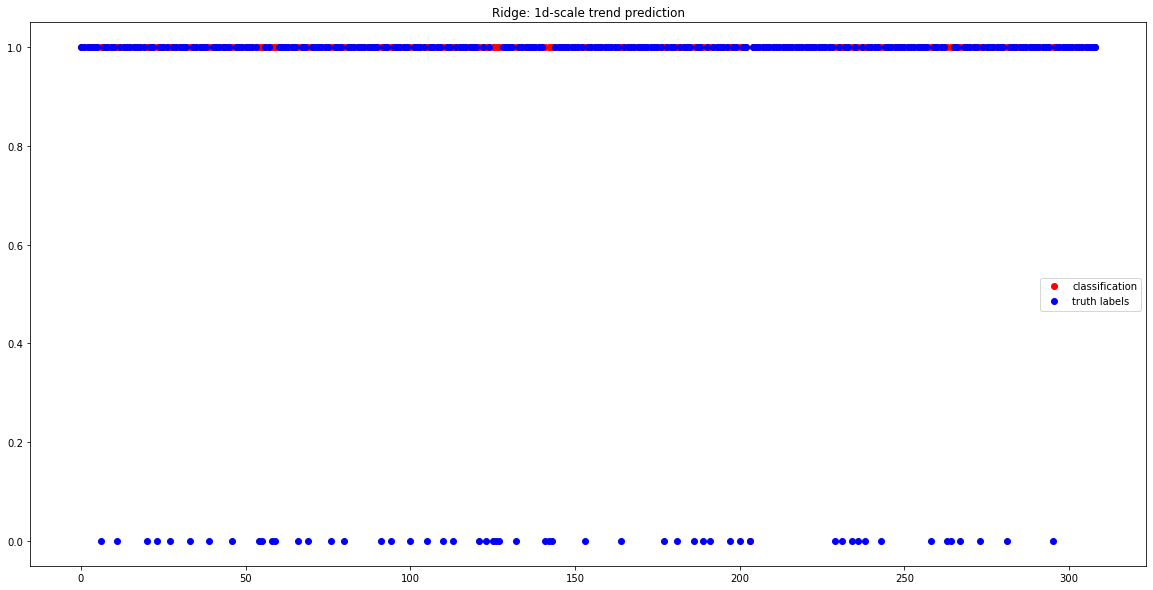

In [6]:
ridge_clf_d = RidgeClassifier().fit(X_train_d, y_train_d)

print('Accuracy of Ridge Classifier (on 1d-scale data)')
print('training set accuracy:', ridge_clf_d.score(X_train_d, y_train_d))
print('test set accuracy:', ridge_clf_d.score(X_test_d, y_test_d))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_d.shape[0]), ridge_clf_d.predict(X_test_d), 'ro', label = "classification")
plt.plot(np.arange(X_test_d.shape[0]), y_test_d, 'bo', label = "truth labels")
plt.title('Ridge: 1d-scale trend prediction')
plt.legend()
plt.show()

Accuracy of Logistic Regression (on 1h-scale data)
training set accuracy: 0.8041973265990334
test set accuracy: 0.803944618599791


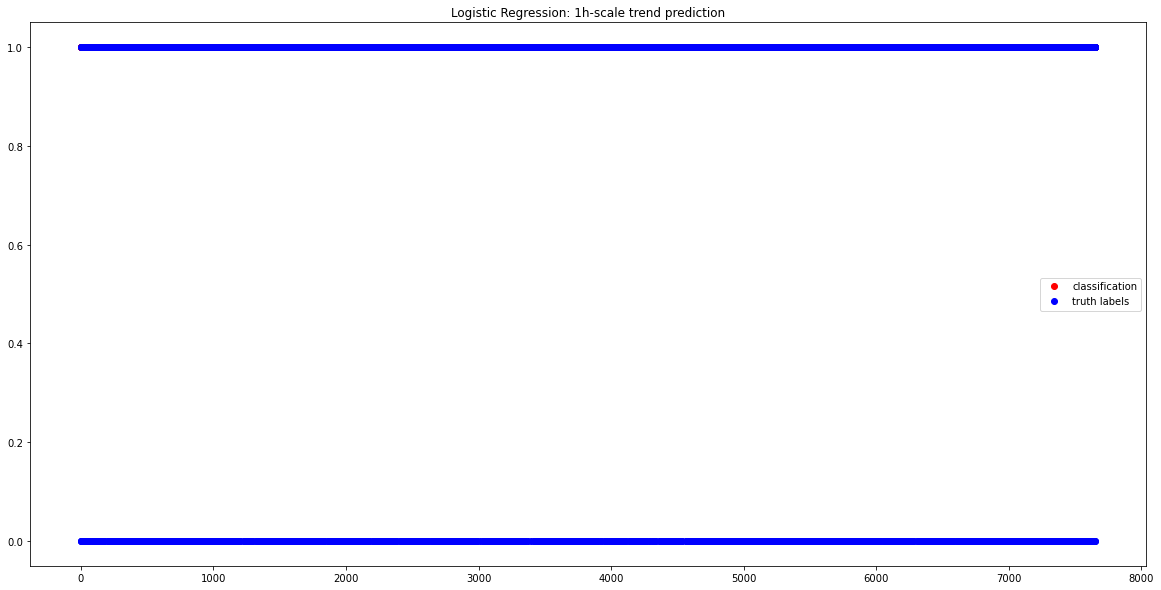

In [12]:
logi_clf_h = LogisticRegression(random_state=0).fit(X_train_h, y_train_h)

print('Accuracy of Logistic Regression (on 1h-scale data)')
print('training set accuracy:', logi_clf_h.score(X_train_h, y_train_h))
print('test set accuracy:', logi_clf_h.score(X_test_h, y_test_h))

plt.figure(figsize=(20,10))
plt.plot(np.arange(X_test_h.shape[0]), logi_clf_h.predict(X_test_h), 'ro', label = "classification")
plt.plot(np.arange(X_test_h.shape[0]), y_test_h, 'bo', label = "truth labels")
plt.title('Logistic Regression: 1h-scale trend prediction')
plt.legend()
plt.show()

In [14]:
logi_clf_d = LogisticRegression(random_state=0).fit(X_train_d, y_train_d)

print('Accuracy of Logistic Regression (on 1d-scale data)')
print('training set accuracy:', logi_clf_d.score(X_train_d, y_train_d))
print('test set accuracy:', logi_clf_d.score(X_test_d, y_test_d))

X_test_d
#y_test_d

# plt.figure(figsize=(20,10))
# plt.plot(np.arange(X_test_d.shape[0]), logi_clf_d.predict(X_test_d), 'ro', label = "classification")
# plt.plot(np.arange(X_test_d.shape[0]), y_test_d, 'bo', label = "truth labels")
# plt.title('Logistic Regression: 1d-scale trend prediction')
# plt.legend()
# plt.show()

Accuracy of Logistic Regression (on 1d-scale data)
training set accuracy: 0.8095238095238095
test set accuracy: 0.8155339805825242


array([[4.05418232e+01, 7.72716924e+03, 3.66683988e+01],
       [5.27685492e+01, 3.90751884e+03, 4.36517369e+01],
       [4.02339274e+01, 8.23678008e+03, 3.15283613e+01],
       [5.47651377e+01, 1.13530475e+04, 3.20033759e+01],
       [5.10041338e+01, 7.41376330e+03, 3.71573351e+01],
       [7.47499967e+01, 4.24760281e+03, 8.63191828e+01],
       [8.38220765e+01, 2.71569944e+04, 8.17309293e+01],
       [8.25290274e+01, 5.79525478e+03, 9.07906169e+01],
       [6.16784629e+01, 3.37939980e+04, 7.58661246e+01],
       [6.55242436e+01, 6.94287926e+03, 7.25154362e+01],
       [5.61204666e+01, 1.40102249e+04, 6.16144055e+01],
       [6.14555023e+01, 8.38969073e+03, 6.56593306e+01],
       [6.96644858e+01, 5.30040130e+03, 7.46428878e+01],
       [4.91104723e+01, 6.49957489e+03, 6.35174406e+01],
       [3.12742378e+01, 5.21893332e+03, 2.20139056e+01],
       [4.63910703e+01, 1.11104115e+04, 4.68488648e+01],
       [4.64586369e+01, 6.68705015e+03, 5.50077548e+01],
       [4.72607874e+01, 8.85553

In [50]:
print('hour scale price data')
print('True count:', len(y_h[y_h == True]))
print('False count:', len(y_h[y_h == False]))

indices = np.where(y_h == True)[0]
if len(y_h[y_h == True]) > len(y_h[y_h == False]):
    indices = np.random.choice(indices, size = len(y_h[y_h == False]), replace = False)
else:
    raise NotImplementedError
    
# Combine the `True` indices with `False` indices
indices = np.concatenate((indices, np.where(y_h == False)[0]))
seed=1234
X_train_h_even, X_test_h_even, y_train_h_even, y_test_h_even = train_test_split(X_h[indices], y_h[indices])
print('Train set True/False ratio:', len(np.where(y_train_h_even == True)[0]), '/', len(np.where(y_train_h_even == False)[0]))
print('Test set True/False ratio:', len(np.where(y_test_h_even == True)[0]), '/', len(np.where(y_test_h_even == False)[0]))

ridge_clf_h_even = RidgeClassifier().fit(X_train_h_even, y_train_h_even)

print('Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)')
print('training set accuracy:', ridge_clf_h_even.score(X_train_h_even, y_train_h_even))
print('test set accuracy:', ridge_clf_h_even.score(X_test_h_even, y_test_h_even))







hour scale price data
True count: 24621
False count: 6002
Train set True/False ratio: 4489 / 4514
Test set True/False ratio: 1513 / 1488
Accuracy of Ridge Classifier (on 1h-scale data, 50/50 dataset)
training set accuracy: 0.6551149616794402
test set accuracy: 0.6704431856047984
